In [1]:
import torch
from typing import Dict, List
from models.pruned_my_tinyyolo2 import PrunedMyTinyYoloV2
from utils.dataloader import VOCDataLoaderPerson
from models.tinyyolov2 import TinyYoloV2
from models.my_tinyyolov2 import MyTinyYoloV2
import tqdm
import time
from utils.ap import precision_recall_levels, ap
from utils.yolo import nms, filter_boxes
from utils.viz import display_result
from utils.utils import plot
import numpy as np

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
def net_acc_and_time(model_class: torch.nn.Module,
            state_dict: Dict,
            testloader: torch.utils.data.DataLoader,
            num_classes=1,
            device=torch.device("cpu"), batches: int=10,
            filter_threshold=0.0375, nms_threshold=0.6) -> float:

    net = model_class(num_classes=num_classes)
    
    net.load_state_dict(state_dict)
    net.to(device)
    net.eval()
    precision = []
    recall = []
    times = []
    
    for idx, (inputs, targets) in tqdm.tqdm(enumerate(testloader), total=len(testloader)):
        inputs = inputs.to(device)
        t_start = time.time()
        outputs = net(inputs)
        outputs = outputs.cpu()
        #filter boxes based on confidence score (class_score*confidence)
        outputs = filter_boxes(outputs, filter_threshold)
        #filter boxes based on overlap
        outputs = nms(outputs, nms_threshold)
        t_end = time.time()
        times.append(t_end - t_start)
        
        #display_result(inputs, outputs, targets, file_path='yolo_prediction.png')
        
        for i in range(len(outputs)):
            p, r = precision_recall_levels(targets[i], outputs[i])
            precision.append(p)
            recall.append(r)

    
    return round(100*ap(precision, recall), 2), np.mean(times)

In [2]:
def net_acc_and_time_onnx(ort_sess,
            testloader: torch.utils.data.DataLoader,
            num_classes=1,
            device=torch.device("cpu"), batches: int=10,
            filter_threshold=0.0375, nms_threshold=0.6) -> float:

    precision = []
    recall = []
    times = []
    
    for idx, (inputs, targets) in tqdm.tqdm(enumerate(testloader), total=len(testloader)):
        inputs = inputs.to(device)
        t_start = time.time()
        output = torch.from_numpy(ort_sess.run(None, {'input': torch_image.numpy()})[0])
        #filter boxes based on confidence score (class_score*confidence)
        outputs = filter_boxes(outputs, filter_threshold)
        #filter boxes based on overlap
        outputs = nms(outputs, nms_threshold)
        t_end = time.time()
        times.append(t_end - t_start)
        
        #display_result(inputs, outputs, targets, file_path='yolo_prediction.png')
        
        for i in range(len(outputs)):
            p, r = precision_recall_levels(targets[i], outputs[i])
            precision.append(p)
            recall.append(r)

    
    return round(100*ap(precision, recall), 2), np.mean(times)

In [ ]:
"""names = ["pretrained", "finetuned_10", "fused_10", "pruned_10"]

models = [TinyYoloV2, TinyYoloV2, MyTinyYoloV2, PrunedMyTinyYoloV2]

filter_thresholds = [0.0125, 0.000, 0.005, 0.15]
nms_thresholds = [0.4, 0.55, 0.525, 0.4]"""
names = ["pruned_10"]

models = [PrunedMyTinyYoloV2]

filter_thresholds = [0.4]
nms_thresholds = [0.0]

#accs, times = [], []

for i in range(len(names)):
    #num_classes = 20 if i == 0 else 1
    num_classes = 1
    sd = torch.load(f"models/configs/voc_{names[i]}.pt")
    acc, t = net_acc_and_time(models[i], sd, VOCDataLoaderPerson(train=False, batch_size=1, shuffle=True), num_classes, batches=4, device=device, filter_threshold=filter_thresholds[i], nms_threshold=nms_thresholds[i])
    accs.append(acc)
    times.append(t)
    print(f"{names[i]}: Acc: {acc}, time: {t}")

In [ ]:
names = ["9x05x55"]


filter_thresholds = [0.4]
nms_thresholds = [0.0]

#accs, times = [], []

for i in range(len(names)):
    #num_classes = 20 if i == 0 else 1
    num_classes = 1
    ort_sess = ort.InferenceSession(f'onnx_models/{names[i]}.onnx')
    acc, t = net_acc_and_time_onnx(models[i], VOCDataLoaderPerson(train=False, batch_size=1, shuffle=True), num_classes, batches=4, device=device, filter_threshold=filter_thresholds[i], nms_threshold=nms_thresholds[i])
    accs.append(acc)
    times.append(t)
    print(f"{names[i]}: Acc: {acc}, time: {t}")

ValueError: x and y must have same first dimension, but have shapes (4,) and (0,)

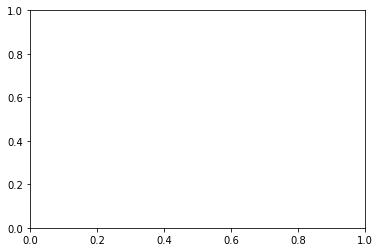

In [8]:
plot([(list(range(4)), accs, 'accuracy')],
      xlabel='index', save_path='testing.png')
plot([(list(range(4)), times, 'time')],
      xlabel='index', save_path='testingtime.png')